This notebook is manual tuning of the neural network.  I made many different networks by hand, and printed some statistics and plots to compare their effectiveness. I used this to determined the best configuration I could find relatively quickly. However, the tuning process should be automated to be much more exhaustive and to tune all of the parameters simulateously, rather than individually. An example of how that might work can be found in "neural_network_automated_tuning.ipynb"

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

# for cross validation
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.pipeline import Pipeline

C:\Users\jfcre\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


A note about the data:

The data is generated by a python 2 script, that saves the data as an array of arrays.

Each row is a different shower. 

The columns are:
1. run #
2. reconstructed energy (using mixed composition assumption)
3. reconstructed zenith angle
4. the sum of the absolute signal time delays past the cut-off distance
5. the total charge >0.6 VEM & <2.0 VEM, past the cut-off distance
6. the number of muon VEMs
7. the number of muons to intersect IceTop tanks
8. the primary type

Run number, and primary type aren't used for the neural networks (actually the run number IS used for the averaged neural network, but that's in it's own notebook). Currently the number of intersecting muons is useless. Most of the showers don't yet contain this information. Until they do, use the number of muon VEMs instead 

Load and convert the data to python3 type

In [2]:
# Columns: Run, Energy, Zen, Time delay, Q400, MuonVEM, nMuon, Type
# Note that right now, nMuon is useless
data = np.load('./data/NN_data.npy')

# convert the python 2 bytes into python 3 format
data_ = []
for i in range(len(data)):
    data_.append([])
    for j in range(0,7):
        data_[i].append(float(data[i,j]))
    # convert types to numbers. proton = 1, iron = 2
    if data[i,7] == b'PPlus':
        data_[i].append(1)
    else:
        data_[i].append(2)
data = np.array(data_)

Select data with $\ log(E) \in (16.0,16.5)\ $  and  $\ cos(zenith) > 0.9$

In [3]:
data_ = []
for shower in data:
    E    = shower[1]
    logE = np.log10(E)
    zen  = shower[2]
    if logE >= 16 and logE <= 16.5 and np.cos(zen) > 0.9:
        data_.append(shower)
data_trimmed = np.array(data_)

Split data into input (X) and output (Y)

In [4]:
X = data_trimmed[:,1:-3]
Y = data_trimmed[:,-3]

split the data into test and training set

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X,Y)

normalize the data sets

In [6]:
# normalize the data because the network will be sensitive
# to relative magnitudes
scaler = StandardScaler()
scaler.fit(x_train)

# apply the scaler to the sets
x_train = scaler.transform(x_train)
x_test  = scaler.transform(x_test)

#### This function prints some stats about the metrics and creates plots to analyze the model. This allows different models to easily be compared.

In [7]:
def analyze_model():
    # print out the mean squared error and mean absolute percentage error of the last 10% of epochs
    look_back = -int(batch_size*0.1)
    look_back_mse  = history.history['mean_squared_error'][look_back:]
    look_back_mape = history.history['mean_absolute_percentage_error'][look_back:]
    print(r' MSE: {0:.3f} ({1:.3f})'.format(np.mean(look_back_mse),np.std(look_back_mse)))
    print(r'MAPE: {0:.3f} ({1:.3f})'.format(np.mean(look_back_mape),np.std(look_back_mape)))

    # plot the metrics vs epoch number

    fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))
    ax1.plot(history.history['mean_absolute_percentage_error'],color='green')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Mean absolute percentage error',color='green')
    ax1.tick_params(axis='y', labelcolor='green')

    ax1_ = ax1.twinx()
    ax1_.plot(history.history['mean_squared_error'],color='blue')
    ax1_.set_ylabel('Mean squared error',color='blue')
    ax1_.tick_params(axis='y', labelcolor='blue')

    # plot predictions vs true values

    PREDICTION = model.predict(x_test)
    TRUTH      = y_test

    # prediction vs truth
    ax2.scatter(TRUTH,PREDICTION,marker='.')
    # line y=x
    xmax = int(1.1*max(TRUTH)+0.5)
    x = np.linspace(-1,xmax)
    ax2.plot(x,x,color='r')
    # stats
    rmse = np.sqrt(mean_squared_error(TRUTH,PREDICTION))
    R2 = r2_score(TRUTH,PREDICTION)
    ax2.text(0.05,0.93,'RMSE = {0:.3f}'.format(rmse),transform=ax2.transAxes,fontsize=12)
    ax2.text(0.05,0.865,'$R^2$ = {0:.3f}'.format(R2),transform=ax2.transAxes,fontsize=12)
    # axes
    ax2.set_xlabel('True muon signal (VEM)')
    ax2.set_ylabel('Predicted muon signal (VEM)')
    ax2.set_xlim(-1,xmax)
    ax2.set_ylim(-1,xmax)
    # title
    fig.suptitle(r'$log_{10}(\ E\ ) \in (16.0,16.5),\quad cos(\theta) > 0.9$')

    # Plot residuals
    residuals = [PREDICTION[i]-TRUTH[i] for i in range(len(TRUTH))]
    ax3.scatter(TRUTH,residuals,marker='.')
    x = np.linspace(0,xmax)
    ax3.plot(x,0*x,color='black')
    ax3.set_xlim(0,xmax)
    ax3.set_ylabel('Residual')
    ax3.set_xlabel('True muon signal (VEM)')
    ax3.text(0.1,0.05,"Sum: {0:.3f}".format(sum(residuals)[0]),transform=ax3.transAxes,fontsize=12)

    plt.subplots_adjust(wspace=0.3)
    plt.show()

# Manual tuning

order: batch size, loss function, architecture, learning rate

There are stars above the best results. These are tested again at the bottom of the notebook using k-fold cross validation

Note: I thought about testing dropout regularization but decided against it as my network is rather small

### Batch size (best ~ 10)

 MSE: 18.420 (0.267)
MAPE: 38.418 (0.304)


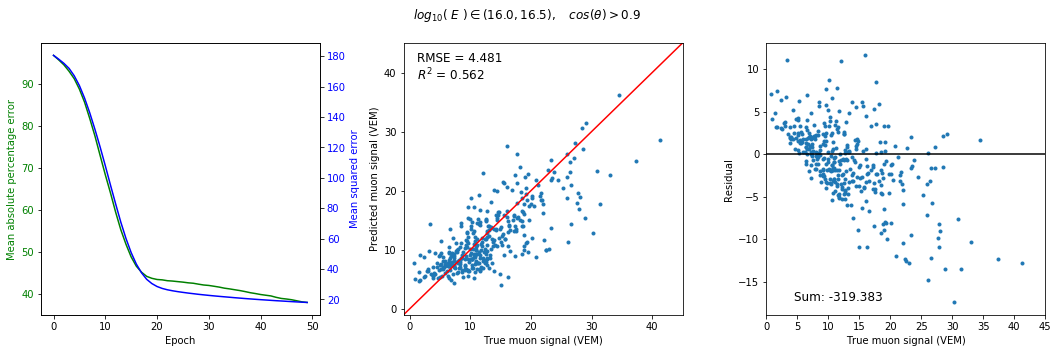

In [8]:
seed = 11
np.random.seed(seed)

# parameters
epochs     = 50
batch_size = 50

# create model
model = Sequential()
model.add(Dense(4,input_dim=4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation=None))

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mse',optimizer='adam',metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)

analyze_model()

 MSE: 12.300 (0.000)
MAPE: 29.673 (0.000)


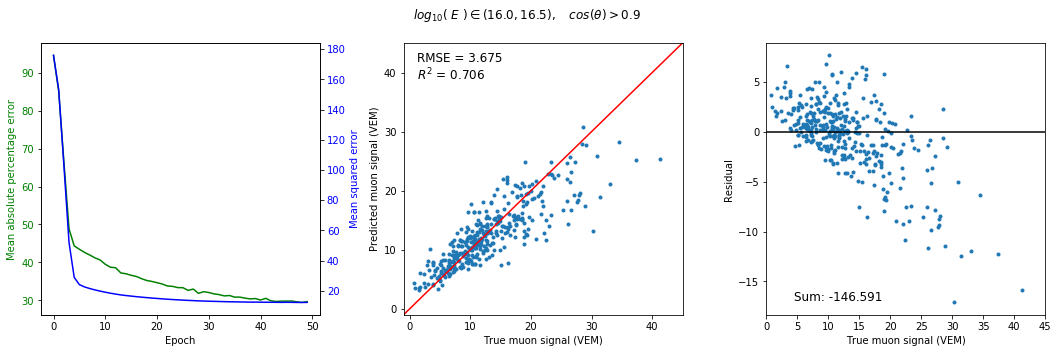

In [9]:
seed = 11
np.random.seed(seed)

# parameters
epochs     = 50
batch_size = 10

# create model
model = Sequential()
model.add(Dense(4,input_dim=4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation=None))

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mse',optimizer='adam',metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)

analyze_model()

 MSE: 15.242 (0.097)
MAPE: 34.802 (0.098)


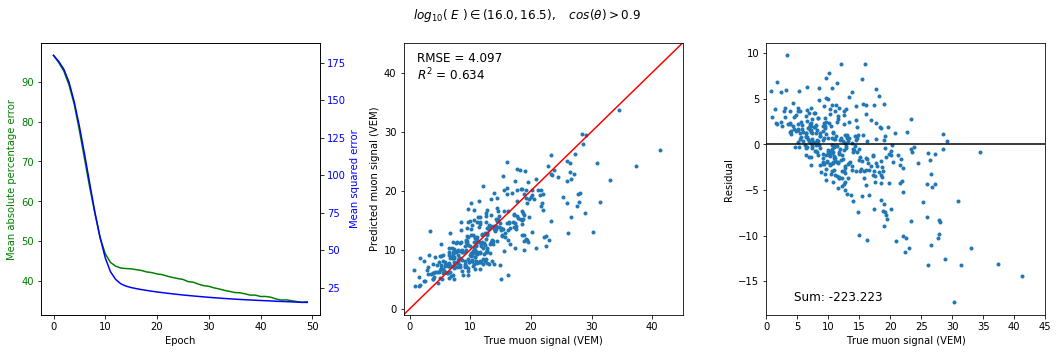

In [10]:
seed = 11
np.random.seed(seed)

# parameters
epochs     = 50
batch_size = 32

# create model
model = Sequential()
model.add(Dense(4,input_dim=4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation=None))

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mse',optimizer='adam',metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)

analyze_model()

### MSE vs MAPE as Loss (MSE is better)

 MSE: 12.159 (0.000)
MAPE: 28.853 (0.000)


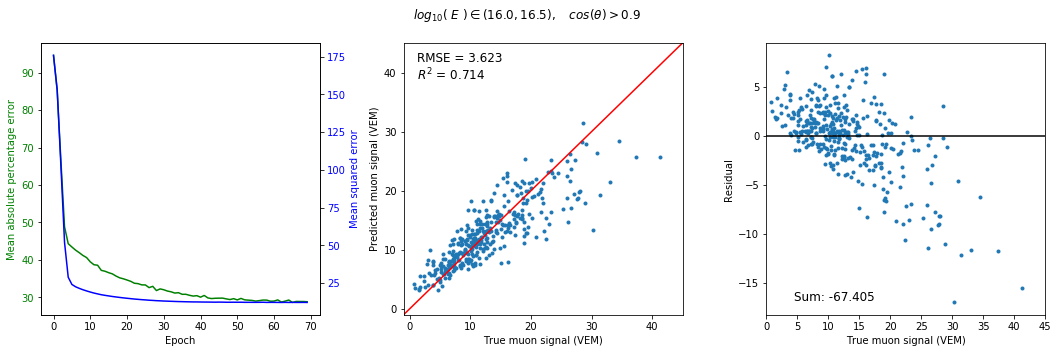

In [11]:
seed = 11
np.random.seed(seed)

# parameters
epochs     = 70
batch_size = 10

# create model
model = Sequential()
model.add(Dense(4,input_dim=4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation=None))

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mse',optimizer='adam',metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)

analyze_model()

 MSE: 13.726 (0.000)
MAPE: 23.655 (0.000)


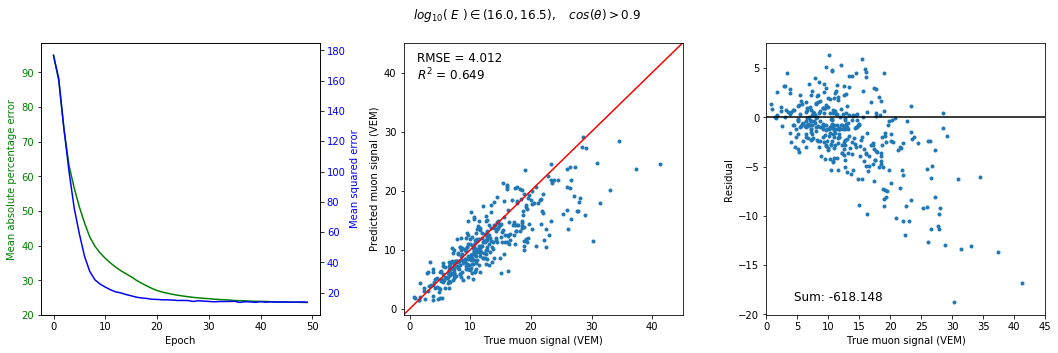

In [12]:
seed = 11
np.random.seed(seed)

# parameters
epochs     = 50
batch_size = 10

# create model
model = Sequential()
model.add(Dense(4,input_dim=4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation=None))

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mape',optimizer='adam',metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)

analyze_model()

### Network Architecture

#### Shallower

 MSE: 12.153 (0.000)
MAPE: 27.223 (0.000)


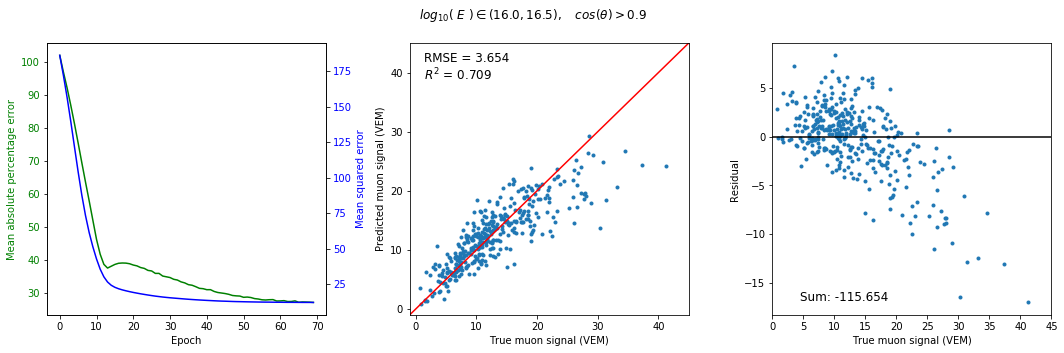

In [13]:
# SHALLOWER

seed = 11
np.random.seed(seed)

# parameters
epochs     = 70
batch_size = 10

# create model
model = Sequential()
model.add(Dense(4,input_dim=4,activation='relu'))
model.add(Dense(1,activation=None))

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mse',optimizer='adam',metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)

analyze_model()

#### Shallower, wider

 MSE: 11.842 (0.000)
MAPE: 25.894 (0.000)


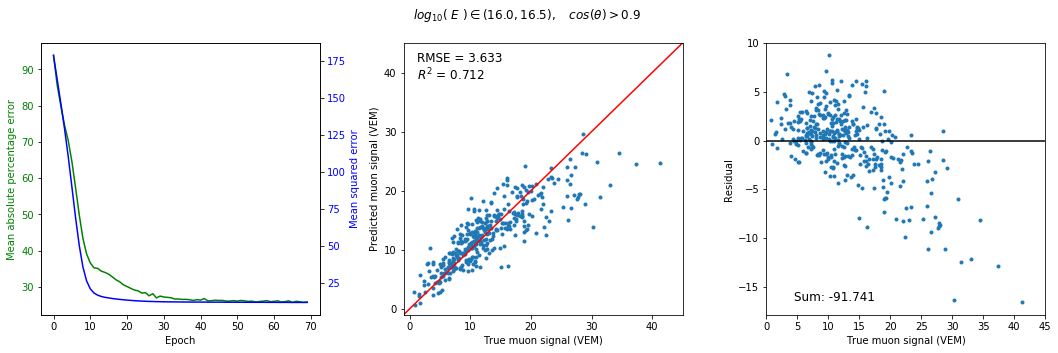

In [14]:
# SHALLOWER, WIDER 1

seed = 11
np.random.seed(seed)

# parameters
epochs     = 70
batch_size = 10

# create model
model = Sequential()
model.add(Dense(8,input_dim=4,activation='relu'))
model.add(Dense(1,activation=None))

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mse',optimizer='adam',metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)

analyze_model()

 MSE: 11.780 (0.000)
MAPE: 26.009 (0.000)


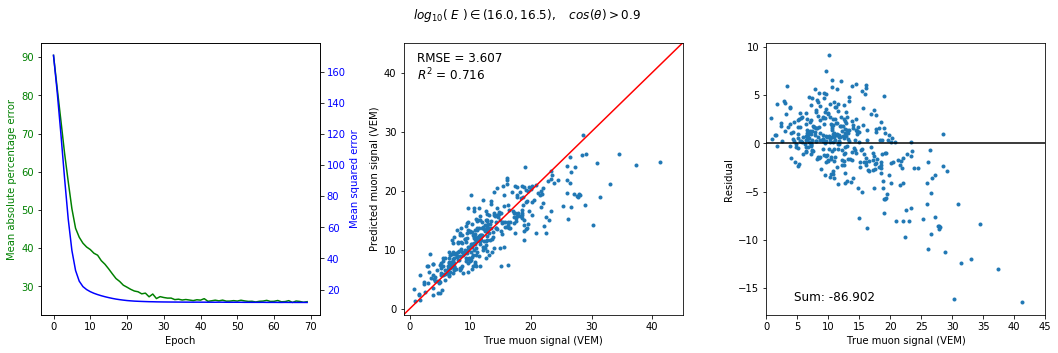

In [15]:
# SHALLOWER, WIDER 2

seed = 11
np.random.seed(seed)

# parameters
epochs     = 70
batch_size = 10

# create model
model = Sequential()
model.add(Dense(12,input_dim=4,activation='relu'))
model.add(Dense(1,activation=None))

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mse',optimizer='adam',metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)

analyze_model()

<img src="http://clipartmag.com/images/star-vector-image-36.png" width="100px">

 MSE: 11.702 (0.000)
MAPE: 25.853 (0.000)


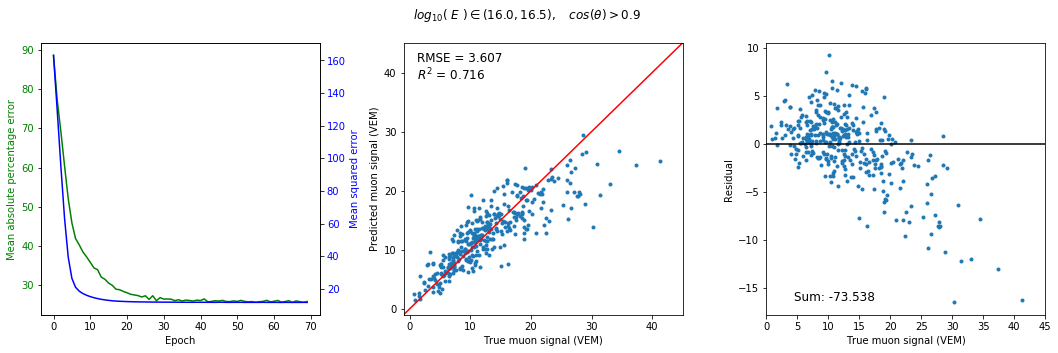

In [16]:
# SHALLOWER, WIDER 3

seed = 11
np.random.seed(seed)

# parameters
epochs     = 70
batch_size = 10

# create model
model = Sequential()
model.add(Dense(20,input_dim=4,activation='relu'))
model.add(Dense(1,activation=None))

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mse',optimizer='adam',metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)

analyze_model()

 MSE: 11.753 (0.000)
MAPE: 25.962 (0.000)


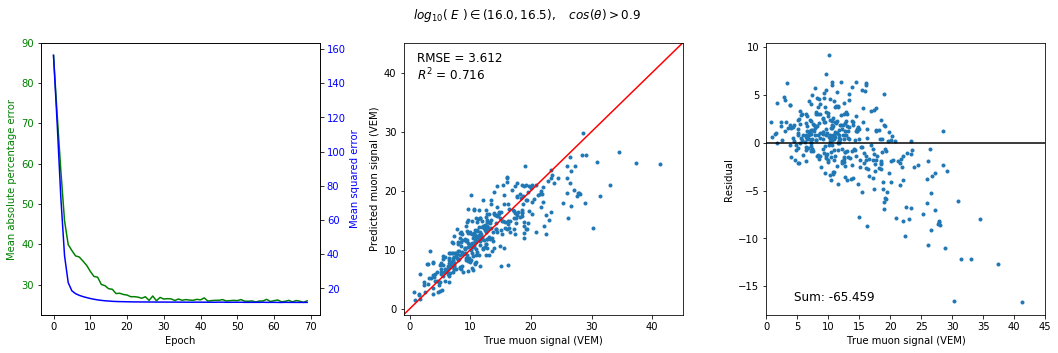

In [17]:
# SHALLOWER, WIDER 4

seed = 11
np.random.seed(seed)

# parameters
epochs     = 70
batch_size = 10

# create model
model = Sequential()
model.add(Dense(30,input_dim=4,activation='relu'))
model.add(Dense(1,activation=None))

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mse',optimizer='adam',metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)

analyze_model()

##### Wider

 MSE: 11.806 (0.000)
MAPE: 26.352 (0.000)


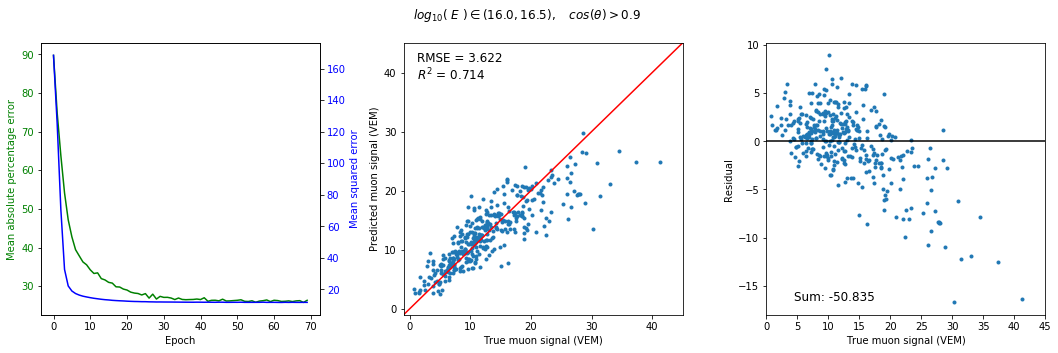

In [18]:
# WIDER 1

seed = 11
np.random.seed(seed)

# parameters
epochs     = 70
batch_size = 10

# create model
model = Sequential()
model.add(Dense(8,input_dim=4,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation=None))

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mse',optimizer='adam',metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)

analyze_model()

 MSE: 11.744 (0.000)
MAPE: 26.303 (0.000)


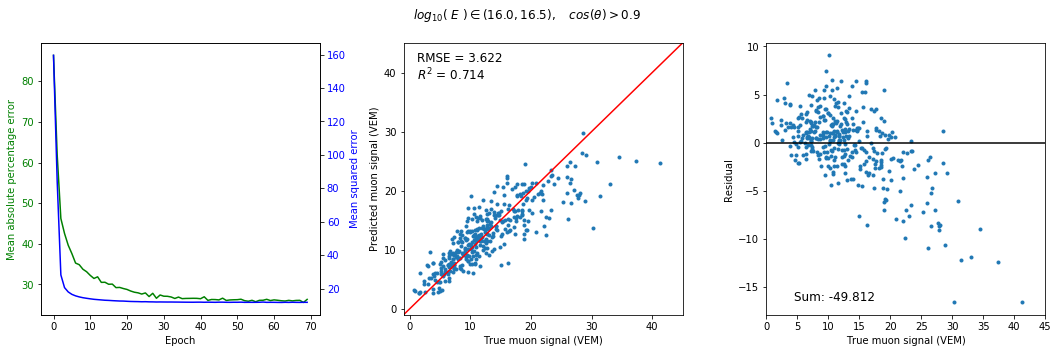

In [19]:
# WIDER 2

seed = 11
np.random.seed(seed)

# parameters
epochs     = 70
batch_size = 10

# create model
model = Sequential()
model.add(Dense(12,input_dim=4,activation='relu'))
model.add(Dense(12,activation='relu'))
model.add(Dense(1,activation=None))

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mse',optimizer='adam',metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)

analyze_model()

 MSE: 11.692 (0.000)
MAPE: 26.036 (0.000)


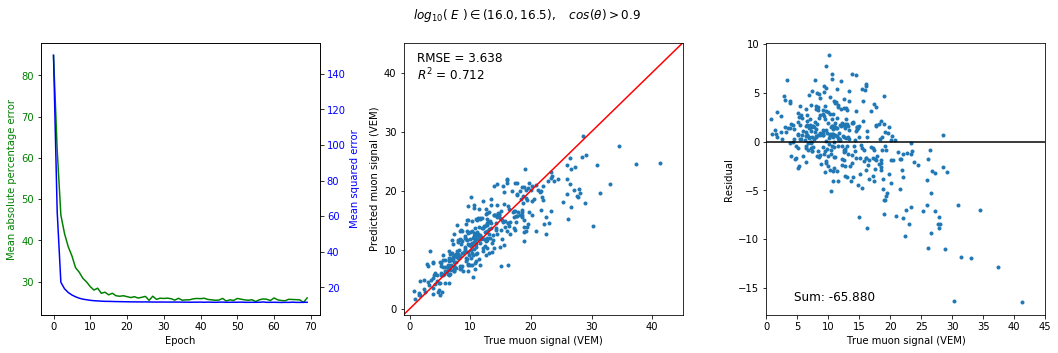

In [20]:
# WIDER 3

seed = 11
np.random.seed(seed)

# parameters
epochs     = 70
batch_size = 10

# create model
model = Sequential()
model.add(Dense(20,input_dim=4,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(1,activation=None))

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mse',optimizer='adam',metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)

analyze_model()

 MSE: 11.706 (0.000)
MAPE: 26.192 (0.000)


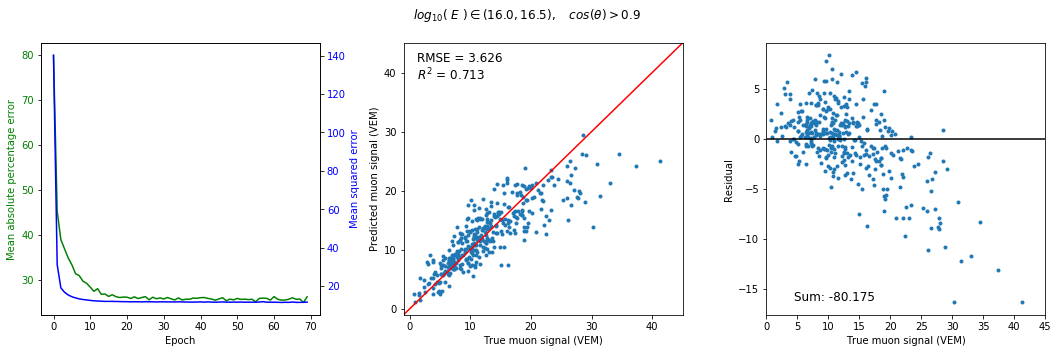

In [21]:
# WIDER 4

seed = 11
np.random.seed(seed)

# parameters
epochs     = 70
batch_size = 10

# create model
model = Sequential()
model.add(Dense(32,input_dim=4,activation='relu'))
model.add(Dense(32,activation='relu'))
model.add(Dense(1,activation=None))

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mse',optimizer='adam',metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)

analyze_model()

 MSE: 12.206 (0.000)
MAPE: 29.395 (0.000)


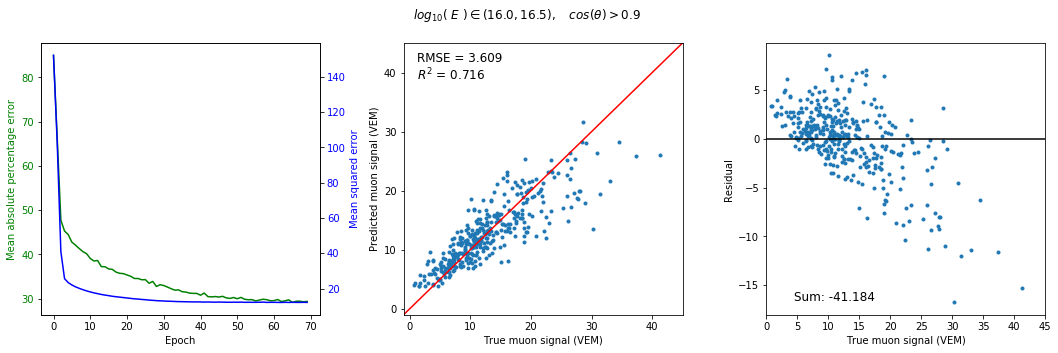

In [22]:
# DEEPER 1

seed = 11
np.random.seed(seed)

# parameters
epochs     = 70
batch_size = 10

# create model
model = Sequential()
model.add(Dense(4,input_dim=4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation=None))

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mse',optimizer='adam',metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)

analyze_model()

 MSE: 11.848 (0.000)
MAPE: 26.433 (0.000)


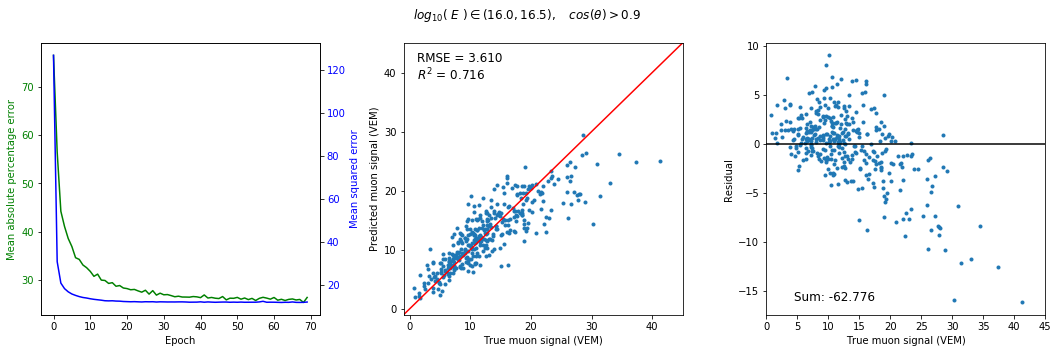

In [23]:
# DEEPER, WIDER 1

seed = 11
np.random.seed(seed)

# parameters
epochs     = 70
batch_size = 10

# create model
model = Sequential()
model.add(Dense(12,input_dim=4,activation='relu'))
model.add(Dense(12,activation='relu'))
model.add(Dense(12,activation='relu'))
model.add(Dense(1,activation=None))

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mse',optimizer='adam',metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)

analyze_model()

 MSE: 11.713 (0.000)
MAPE: 26.354 (0.000)


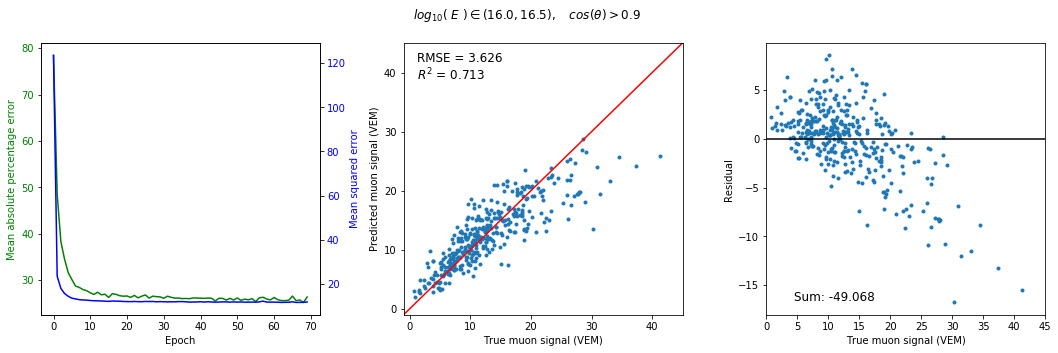

In [24]:
# DEEPER, WIDER 2

seed = 11
np.random.seed(seed)

# parameters
epochs     = 70
batch_size = 10

# create model
model = Sequential()
model.add(Dense(20,input_dim=4,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(1,activation=None))

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mse',optimizer='adam',metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)

analyze_model()

#### Tuning the optimizer

<img src="http://clipartmag.com/images/star-vector-image-36.png" width="100px">

 MSE: 11.655 (0.000)
MAPE: 25.764 (0.000)


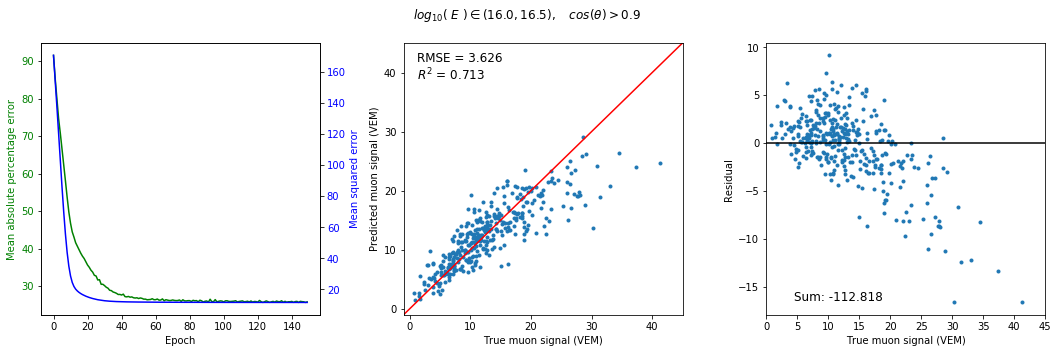

In [25]:
# LEARNING RATE 1

seed = 11
np.random.seed(seed)

# parameters
epochs     = 150
batch_size = 10

# create model
model = Sequential()
model.add(Dense(20,input_dim=4,activation='relu'))
model.add(Dense(1,activation=None))

# optimizer (default lr = 0.001)
adam = Adam(lr=0.0005)

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mse',optimizer=adam,metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)

analyze_model()

 MSE: 12.447 (0.000)
MAPE: 28.813 (0.000)


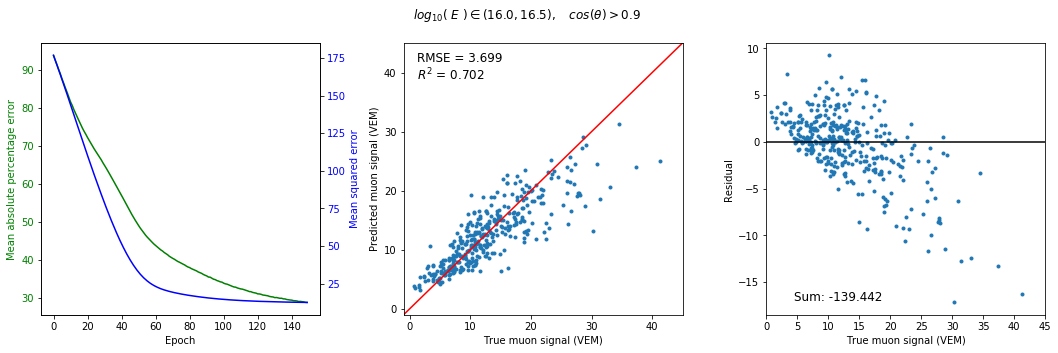

In [26]:
# LEARNING RATE 2

seed = 11
np.random.seed(seed)

# parameters
epochs     = 150
batch_size = 10

# create model
model = Sequential()
model.add(Dense(20,input_dim=4,activation='relu'))
model.add(Dense(1,activation=None))

# optimizer (default lr = 0.001)
adam = Adam(lr=0.0001)

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mse',optimizer=adam,metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)

analyze_model()

 MSE: 11.785 (0.000)
MAPE: 25.479 (0.000)


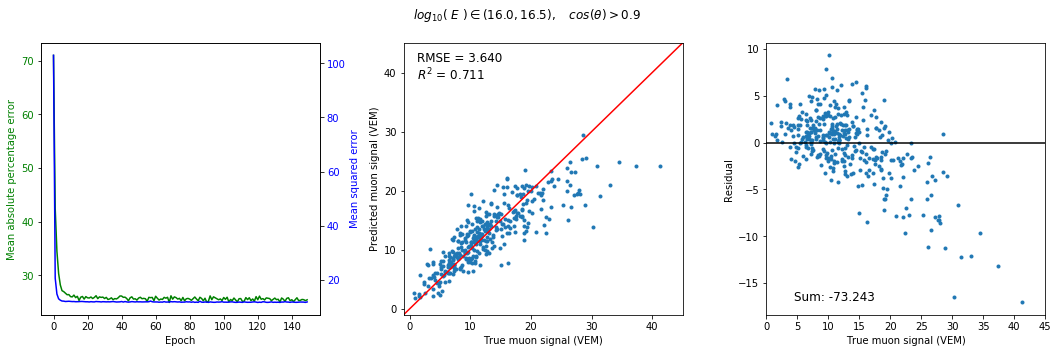

In [27]:
# LEARNING RATE 3

seed = 11
np.random.seed(seed)

# parameters
epochs     = 150
batch_size = 10

# create model
model = Sequential()
model.add(Dense(20,input_dim=4,activation='relu'))
model.add(Dense(1,activation=None))

# optimizer (default lr = 0.001)
adam = Adam(lr=0.005)

# compile model
# loss function: mean square log error
# metric: mean absolute percentage error
model.compile(loss='mse',optimizer=adam,metrics=['mape','mse'])

# fit the model to the data
history = model.fit(x_train,y_train,epochs=epochs,batch_size=batch_size,verbose=0)

analyze_model()

### Cross validation on two candidate models

both with 4 -> 20 -> 1

both with batch = 10, epochs = 70

one with lr = 0.001, one with lr = 0.0005


In [28]:
def model1():
    # model
    model = Sequential()
    model.add(Dense(20,input_dim=4,activation='relu'))
    model.add(Dense(1,activation=None))
    # optimizer
    lr = 0.001
    adam = Adam(lr=lr)
    # compile
    model.compile(loss='mean_squared_error',optimizer=adam)
    return model

In [29]:
# parameters
epochs     = 70
batch_size = 10

seed = 11
np.random.seed(seed)

# The Pipeline - 1. rescale data, 2. wrapper for sklearn
scaler = ('rescale',StandardScaler())
estimator = ('mlp',KerasRegressor(build_fn=model1,epochs=epochs,batch_size=batch_size,verbose=0))
pipeline = Pipeline([scaler,estimator])

# evaluate the model with kfold cross-validation
n_splits = 17 # data set has len = 1462. 17 is a divisor close to 10
kfold = KFold(n_splits=n_splits,random_state=seed)

results = cross_val_score(pipeline,X,Y,cv=kfold)
print("Results: %.2f (%.2f) MSE" % (-1*results.mean(), results.std()))

Results: 12.56 (3.60) MSE


In [30]:
def model2():
    # model
    model = Sequential()
    model.add(Dense(20,input_dim=4,activation='relu'))
    model.add(Dense(1,activation=None))
    # optimizer
    lr = 0.0005
    adam = Adam(lr=lr)
    # compile
    model.compile(loss='mean_squared_error',optimizer=adam)
    return model

In [31]:
# parameters
epochs     = 70
batch_size = 10

seed = 11
np.random.seed(seed)

# The Pipeline - 1. rescale data, 2. wrapper for sklearn
scaler = ('rescale',StandardScaler())
estimator = ('mlp',KerasRegressor(build_fn=model2,epochs=epochs,batch_size=batch_size,verbose=0))
pipeline = Pipeline([scaler,estimator])

# evaluate the model with kfold cross-validation
n_splits = 17 # data set has len = 1462. 17 is a divisor close to 10
kfold = KFold(n_splits=n_splits,random_state=seed)

results = cross_val_score(pipeline,X,Y,cv=kfold)
print("Results: %.2f (%.2f) MSE" % (-1*results.mean(), results.std()))

Results: 12.57 (3.49) MSE


Looks like the learning rate really doesn't matter. I will use learning rate = 0.001 because it is the faster of the two